In [1]:
import random
import glob
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import font_manager
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Inspection of the dataset

In [2]:
import pandas as pd

In [3]:
train_csv = pd.read_csv("lits_train.csv")
test_csv = pd.read_csv("lits_test.csv")

In [4]:
train_csv.tail()

,filepath,liver_maskpath,tumor_maskpath,study_number,instance_number,liver_mask_empty,tumor_mask_empty
38518,./lits-png/dataset_6/volume-130_509.png,./lits-png/dataset_6/segmentation-130_livermas...,./lits-png/dataset_6/segmentation-130_lesionma...,130,253,True,True
38519,./lits-png/dataset_6/volume-130_254.png,./lits-png/dataset_6/segmentation-130_livermas...,./lits-png/dataset_6/segmentation-130_lesionma...,130,254,False,False
38520,./lits-png/dataset_6/volume-130_510.png,./lits-png/dataset_6/segmentation-130_livermas...,./lits-png/dataset_6/segmentation-130_lesionma...,130,254,True,True
38521,./lits-png/dataset_6/volume-130_255.png,./lits-png/dataset_6/segmentation-130_livermas...,./lits-png/dataset_6/segmentation-130_lesionma...,130,255,False,False
38522,./lits-png/dataset_6/volume-130_511.png,./lits-png/dataset_6/segmentation-130_livermas...,./lits-png/dataset_6/segmentation-130_lesionma...,130,255,True,True


In [5]:
class LiTSDataset(Dataset):
    """LiTS dataset."""

    def __init__(self, csv_file, liver_or_lesion="liver_maskpath",transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv(csv_file)
        self.liver_or_lesion = liver_or_lesion
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = np.array(Image.open(self.csv.loc[idx]["filepath"]).convert("RGB"))
        mask = np.array(Image.open(self.csv.loc[idx][self.liver_or_lesion]).convert("L"), dtype=np.float32)

        
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [6]:
train_liver_dataset = LiTSDataset(csv_file="lits_train.csv")
train_lesion_dataset = LiTSDataset(csv_file="lits_train.csv", liver_or_lesion="tumor_maskpath")
train_liver_loader = DataLoader(train_liver_dataset, batch_size=16, shuffle=True)
train_lesion_loader = DataLoader(train_lesion_dataset, batch_size=16, shuffle=True)

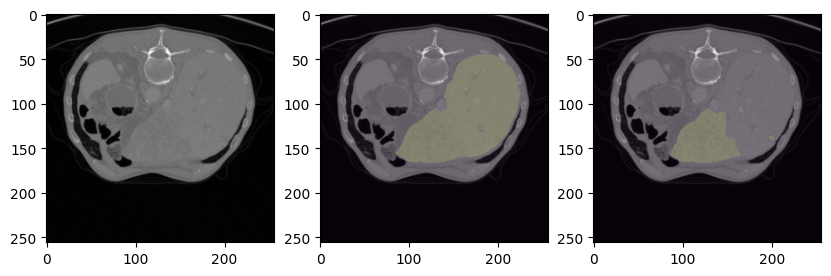

In [7]:
_, figure = plt.subplots(1, 3, figsize=(10, 30))

figure[0].imshow(train_liver_dataset[38522][0])
figure[1].imshow(train_liver_dataset[38522][0], 'gray', interpolation=None)
figure[1].imshow(train_liver_dataset[38522][1], interpolation=None, alpha=0.1)
figure[2].imshow(train_lesion_dataset[38522][0], 'gray', interpolation=None)
figure[2].imshow(train_lesion_dataset[38522][1], interpolation=None, alpha=0.1)
plt.show()

In [8]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.float().permute(0, 3, 1, 2).to(device)
            y = y.to(device).unsqueeze(1).float()
            preds = torch.sigmoid(model(x)['out'])
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
        
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [9]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 5
NUM_WORKERS = 2
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 240
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "data/train_images"
TRAIN_MASK_DIR = "data/train_masks"
VAL_IMG_DIR = "data/val_images"
VAL_MASK_DIR = "data/val_masks"

In [10]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        # print(type(data))
        data = data.float().permute(0, 3, 1, 2).to(device=DEVICE)

        targets = targets.float().unsqueeze(1).to(device=DEVICE)
        # print(data.shape, targets.shape)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            
            predictions = predictions['out']
            predictions = torch.sigmoid(predictions)
            # predictions = (predictions > 0.5).float()
            loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


In [11]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(num_classes=1)

In [12]:
from monai.losses.dice import *  # NOQA

import torch

from monai.losses import FocalLoss


model.cuda()
loss_fn = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()


In [13]:
test_liver_dataset = LiTSDataset(csv_file="lits_test.csv")
test_lesion_dataset = LiTSDataset(csv_file="lits_test.csv", liver_or_lesion="tumor_maskpath")
test_liver_loader = DataLoader(test_liver_dataset, batch_size=16, shuffle=False)
test_lesion_loader = DataLoader(test_lesion_dataset, batch_size=16, shuffle=False)

In [14]:
import torchvision

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.float().permute(0, 3, 1, 2).to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x)['out'])
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

In [15]:
for epoch in range(NUM_EPOCHS):
    train_fn(train_liver_loader, model, optimizer, loss_fn, scaler)
    # check accuracy
    check_accuracy(test_liver_loader, model, device=DEVICE)

    # save_predictions_as_imgs(test_liver_loader, model, folder="saved_images/", device=DEVICE)

  0%|          | 0/2408 [00:00<?, ?it/s]

Got 198291063/199098368 with acc 99.59
Dice score: 0.6030453443527222


  0%|          | 0/2408 [00:00<?, ?it/s]

Got 198583497/199098368 with acc 99.74
Dice score: 0.6238523721694946


  0%|          | 0/2408 [00:00<?, ?it/s]

Got 198460330/199098368 with acc 99.68
Dice score: 0.6268393993377686


  0%|          | 0/2408 [00:00<?, ?it/s]

Got 198630119/199098368 with acc 99.76
Dice score: 0.641315221786499


  0%|          | 0/2408 [00:00<?, ?it/s]

Got 198609303/199098368 with acc 99.75
Dice score: 0.6427761912345886


In [51]:
def save_checkpoint(state, filename="try_02.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [52]:
checkpoint = {"state_dict": model.state_dict(),"optimizer":optimizer.state_dict()}
save_checkpoint(checkpoint)

=> Saving checkpoint


In [46]:
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [30]:
load_checkpoint(torch.load('try_01.tar'), model=model)

=> Loading checkpoint
